Required time: 90.4142498000001s
Critical path: [0, 3, 5, 7, 8, 9, 10, 11, 12, 13, 14, 16, 17, 18, 22, 23, 24, 28, 29, 30, 32, 35, 36, 39, 41, 42, 43, 44, 46, 48, 49, 50, 52, 54, 55, 57, 58, 59, 61, 67, 71, 78, 79, 81, 84, 85, 86, 87, 88, 90, 94, 95, 96, 97, 98, 101, 103, 106, 107, 108, 112, 113, 115, 116, 117, 118, 119, 120, 122, 123, 125, 126, 127, 130, 132, 133, 136, 137, 140, 142, 144, 145, 147, 148, 149, 150, 151, 152, 153, 154, 156, 157, 158, 159, 160, 163, 164, 168, 169, 171, 172, 174, 175, 176, 179, 182, 183, 185, 188, 189, 190, 193, 194, 196, 199, 200, 201, 202, 203, 204, 207, 208, 210, 211, 212, 217, 218, 221, 223, 224, 225, 228, 229, 233, 234, 236, 237, 240, 242, 243, 244, 245, 246, 247, 248, 249, 250, 253, 254, 255, 256, 257, 258, 260, 261, 262, 263, 264, 265, 266, 267, 269, 270, 271, 272, 273, 275, 279, 283, 285, 286, 288, 289, 291, 293, 295, 297, 298, 301, 304, 305, 307, 308, 309, 310, 311, 313, 318, 319, 320, 323, 324, 327, 329, 330, 332, 336, 339, 340, 342, 343, 344, 34

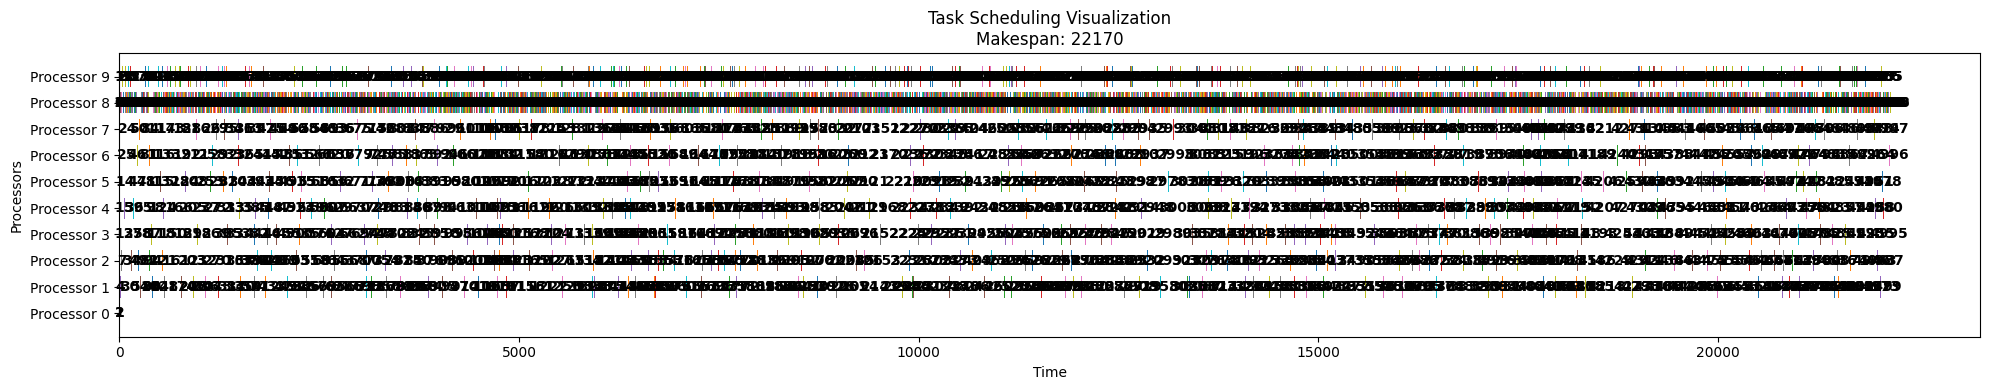

High memory processors:
[8, 9]
Low memory processors:
[0, 1, 2, 3, 4, 5, 6, 7]
High memory nodes:
[0, 3, 5, 6, 8, 10, 11, 13, 16, 17, 22, 23, 26, 31, 32, 33, 40, 42, 43, 45, 47, 51, 53, 62, 63, 64, 66, 67, 68, 70, 71, 72, 74, 77, 79, 83, 89, 91, 92, 93, 95, 99, 105, 107, 109, 110, 112, 120, 126, 135, 136, 142, 146, 148, 149, 151, 155, 157, 158, 164, 165, 167, 168, 170, 172, 178, 179, 180, 181, 185, 186, 187, 193, 194, 196, 197, 200, 201, 210, 215, 217, 223, 225, 226, 229, 231, 233, 234, 239, 245, 246, 251, 254, 263, 264, 268, 274, 275, 277, 278, 280, 281, 283, 284, 285, 286, 287, 289, 294, 296, 297, 301, 309, 311, 314, 319, 321, 323, 325, 327, 329, 330, 336, 338, 342, 343, 353, 357, 366, 367, 368, 369, 370, 372, 373, 378, 381, 383, 387, 388, 394, 395, 399, 405, 409, 410, 411, 417, 419, 420, 426, 428, 430, 436, 437, 449, 451, 452, 453, 455, 458, 460, 465, 466, 468, 475, 476, 477, 478, 480, 483, 486, 488, 497, 501, 507, 509, 516, 518, 519, 522, 530, 534, 537, 538, 541, 543, 545, 547, 548

In [8]:
import random
import heapq
import json
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib
from typing import Any, List, Tuple, Optional
from networkx.classes import DiGraph
from timeit import default_timer as timer

matplotlib.use('TkAgg')

def generate_random_dag(num_nodes: int) -> dict[str, list[Any]]:
    edges = []
    for j in range(1, num_nodes):
        if random.choice([True, False]):
            edges.append((0, j))
    for i in range(1, num_nodes - 1):
        if random.choice([True, False]):
            edges.append((i, num_nodes - 1))
    for i in range(1, num_nodes - 1):
        for j in range(i + 1, num_nodes - 1):
            if random.choice([True, False]):
                edges.append((i, j))
    return {"nodes": list(range(num_nodes)), "edges": edges}

def assign_subsets_and_features(dag: dict[str, list[Any]]) -> DiGraph:
    G = nx.DiGraph()
    G.add_nodes_from(dag["nodes"])
    G.add_edges_from(dag["edges"])

    levels = {node: 0 for node in G.nodes}
    for node in nx.topological_sort(G):
        for successor in G.successors(node):
            levels[successor] = max(levels[successor], levels[node] + 1)

    features = {node: random.randint(1, 10) for node in G.nodes}
    memory = {node: random.randint(128, 1024) for node in G.nodes}

    nx.set_node_attributes(G, levels, "subset")
    nx.set_node_attributes(G, features, "feature")
    nx.set_node_attributes(G, memory, "memory")

    return G

def filter_nodes_by_memory(G: DiGraph, Memlimite: int) -> Tuple[List[int], List[int]]:
    high_memory_nodes = []
    low_memory_nodes = []

    for node in G.nodes:
        memory = G.nodes[node]["memory"]
        if memory > Memlimite:
            high_memory_nodes.append(node)
        else:
            low_memory_nodes.append(node)

    return high_memory_nodes, low_memory_nodes

def nb_nb(G: DiGraph) -> Tuple[int, int]:
    pmem = sum(1 for node in G.nodes if G.nodes[node]['memory'] > 500)
    gmem = len(G.nodes) - pmem
    return pmem, gmem

class Task:
    def __init__(self, id: int, duration: int):
        self.id = id
        self.duration = duration
        self.start_time: Optional[int] = None
        self.end_time: Optional[int] = None
        self.processor: Optional[int] = None

def find_earliest_processor(processor_times: List[int], task_memory: int, processor_lists: List[List[int]], Memlimite: int) -> int:
    type1_processors, type2_processors = processor_lists

    if task_memory > Memlimite:
        available_processors = type2_processors
    else:
        available_processors = type1_processors + type2_processors

    return min(available_processors, key=lambda p: processor_times[p])

def find_same_processor(predecessors: List[int], schedule: List[Task]) -> Optional[int]:
    for task in schedule:
        if task.id in predecessors:
            return task.processor
    return None

def calculate_latest_finish(graph: DiGraph, task_durations: dict[int, int], debug: bool = False) -> dict[int, int]:
    latest_finish = {node: 0 for node in graph.nodes}
    topo_order = list(nx.topological_sort(graph))
    if debug:
        print(topo_order)

    for node in topo_order:
        predecessors = list(graph.predecessors(node))
        if predecessors:
            latest_finish[node] = max(latest_finish[pred] + task_durations[pred] for pred in predecessors)

    return latest_finish

def find_critical_path(dag: DiGraph) -> Tuple[List[int], int]:
    topological_order = list(nx.topological_sort(dag))
    longest_path_length = {node: 0 for node in dag.nodes}
    predecessor = {node: None for node in dag.nodes}

    for node in topological_order:
        for succ in dag.successors(node):
            new_length = longest_path_length[node] + dag.nodes[node]["feature"]
            if new_length > longest_path_length[succ]:
                longest_path_length[succ] = new_length
                predecessor[succ] = node

    end_node = max(longest_path_length, key=longest_path_length.get)
    critical_path = []
    node = end_node
    while node is not None:
        critical_path.append(node)
        node = predecessor[node]

    return list(reversed(critical_path)), longest_path_length[end_node]

def visualize_schedule(schedule: List[Task], num_processors: int, makespan: int):
    _, ax = plt.subplots(figsize=(20, 4))
    for task in schedule:
        if task.start_time is None or task.processor is None:
            continue

        ax.barh(task.processor, task.duration, left=task.start_time, height=0.8, label=f"Task {task.id}")
        ax.text(task.start_time + task.duration / 2, task.processor, str(task.id),
                va='center', ha='center', fontsize=10, color='black', fontweight='bold')

    ax.set_xlabel("Time")
    ax.set_ylabel("Processors")
    ax.set_yticks(range(num_processors))
    ax.set_yticklabels([f"Processor {i}" for i in range(num_processors)])
    ax.set_title(f"Task Scheduling Visualization\nMakespan: {makespan}")
    plt.tight_layout()
    plt.show()

def plot_dag(G: DiGraph) -> None:
    pos = nx.multipartite_layout(G, subset_key="subset")
    labels = {node: f"{node}\n{G.nodes[node]['feature']}" for node in G.nodes}

    plt.figure(figsize=(8, 6))
    nx.draw(G, pos, with_labels=True, labels=labels, node_size=700, node_color="skyblue", arrowsize=20)
    plt.show()

def MCP_with_comm_failure_hétéregous_ressources(graph: DiGraph, task_durations: dict[int, int], processor_lists: List[List[int]], num_processors_type1: int, num_processors_type2: int, Memlimite: int, debug: bool = False) -> Tuple[List[Task], int]:
    latest_finish = calculate_latest_finish(graph, task_durations, debug)

    if debug:
        print(latest_finish)

    priority_queue = []
    for node in graph.nodes:
        heapq.heappush(priority_queue, (latest_finish[node], node))

    schedule = []
    min_processor_time = 0
    assigned_tasks = set()
    processor_times = [0] * (num_processors_type1 + num_processors_type2)

    failed_processor = 0
    failure_time = 10

    if debug:
        print(f"Processor {failed_processor} will fail at time {failure_time}")

    while priority_queue:
        _, node = heapq.heappop(priority_queue)
        if debug:
            print(f"node: {node}")
        if node in assigned_tasks:
            continue

        dependencies = list(graph.predecessors(node))
        max_dependency_end = max((task.end_time for task in schedule if task.id in dependencies), default=0)
        start_time = max(min_processor_time, max_dependency_end)
        preferred_processor = find_same_processor(dependencies, schedule)

        if preferred_processor is not None:
            if graph.nodes[node]['memory'] > Memlimite and preferred_processor in processor_lists[0]:
                # Reassign to a high memory processor
                processor = find_earliest_processor(processor_times, graph.nodes[node]['memory'], processor_lists, Memlimite)
            else:
                processor = preferred_processor
        else:
            processor = find_earliest_processor(processor_times, graph.nodes[node]['memory'], processor_lists, Memlimite)

        if start_time >= failure_time and processor == failed_processor:
            if debug:
                print(f"Processor {failed_processor} failed. Reassigning task {node}.")
            available_processors = [p for p in range(len(processor_times)) if p != failed_processor]
            processor = min(available_processors, key=lambda p: processor_times[p])

        if preferred_processor is not None and processor != preferred_processor:
            start_time += 1  # Communication cost

        start_time = max(start_time, processor_times[processor])

        task = Task(node, task_durations[node])
        task.start_time = start_time
        task.end_time = start_time + task.duration
        task.processor = processor
        schedule.append(task)
        assigned_tasks.add(node)
        processor_times[processor] = task.end_time
        min_processor_time = min(processor_times)

    schedule.sort(key=lambda t: t.start_time)
    makespan = max(processor_times)
    return schedule, makespan


%matplotlib inline  

start = timer()
Memlimite = 700

num_nodes = 5000
processor_lists = [[0, 1, 2, 3, 4, 5, 6, 7], [8, 9]]
num_processors_type1, num_processors_type2 = len(processor_lists[0]), len(processor_lists[1])

dag = generate_random_dag(num_nodes)
G = assign_subsets_and_features(dag)
task_durations = {node: G.nodes[node]['feature'] for node in G.nodes}

communication_cost = 1
schedule, makespan = MCP_with_comm_failure_hétéregous_ressources(G, task_durations, processor_lists, num_processors_type1, num_processors_type2, Memlimite)
end = timer()

print(f"Required time: {end-start}s")
critical_path, longest_path_length = find_critical_path(G)
print(f"Critical path: {critical_path}")
print(f"Longest path length: {longest_path_length}")
visualize_schedule(schedule, num_processors_type1 + num_processors_type2, makespan)

print("High memory processors:")
print(processor_lists[1])
print("Low memory processors:")
print(processor_lists[0])

high_memory_nodes, low_memory_nodes = filter_nodes_by_memory(G, Memlimite)
print("High memory nodes:")
print(high_memory_nodes)
print("Low memory nodes:")
print(low_memory_nodes)

